In [1]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import time
from radam import RAdam
import sys
import pandas as pd
import matplotlib
from scipy import signal
from natsort import natsorted
from scipy.io import loadmat
import math
import gc
import wandb
from pynvml.smi import nvidia_smi
from pytorch_msssim import ssim
import copy
import pytorch_warmup as pw
from skimage.transform import resize
from scipy.ndimage import gaussian_filter

from velocitygpt.utils import *
from velocitygpt.pytorchtools import EarlyStopping

pd.set_option('display.max_rows', None)
torch.cuda.empty_cache()

print("Current working directory: {}".format(os.getcwd()))

Current working directory: /home/randycm/Documents/Research/Transformers/testing/ElasticGPT


In [282]:
seed = 123
set_mpl_params()

In [4]:
def PSNR(x, xinv):
    return 10 * torch.log10(len(xinv) * torch.max(xinv) ** 2 / torch.linalg.norm(x - xinv) ** 2)

In [5]:
class ElasticGPTDataset(torch.utils.data.Dataset):
    """PyTorch Dataset wrapper for ElasticGPT."""

    def __init__(self, data):
        self.data = data
    def __getitem__(self, idx):
        return {key: val[idx].clone().detach() for key, val in self.data.items()}
    def __len__(self):
        return len(self.data['input'])

In [6]:
def setup():
    set_seed(seed)
    torch.backends.cudnn.benchmark = False
    gc.collect()
    torch.cuda.empty_cache()
    try:
        optim.zero_grad()
    except:
        pass

In [7]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('cpu')
print("Using device: {}".format(device))

Using device: cuda:0


## Configuration

In [8]:
class ElasticGPTConfig(object):
    def __init__(self,
                 hidden_size=256,
                 num_hidden_layers=4,
                 num_attention_heads=4,
                 num_hidden_ffn=4):
        self.hidden_size = hidden_size
        self.num_hidden_layers = num_hidden_layers
        self.num_attention_heads = num_attention_heads
        self.num_hidden_ffn = num_hidden_ffn
    def __call__(self):
        print(self.__dict__)

In [9]:
class VectorQuantizedVAEConfig(object):
    def __init__(self,
                 input_dim=1,
                 dim=256,
                 K=512):
        self.input_dim = input_dim
        self.dim = dim
        self.K = K
    def __call__(self):
        print(self.__dict__)

In [10]:
def inject_default_params(config):    
    # Data Parameter
    config.dataset = './data/v0_0/'
    config.dataset_path = './data/v0_0/'
    config.batch_size = 256
    config.prop = None

    # Model Parameter
    config.layer_norm_eps = 1e-12
    config.hidden_dropout_prob = 0.1
    config.vocab_size = 70
    config.intermediate_size = config.hidden_size*config.num_hidden_ffn
    # config.initializer_range = .00005
    config.max_length = 70
    config.max_position_embeddings = config.max_length
    config.position_embedding_type = 'sincos'
    config.input_type = 'trace'
    config.embedding_type = 'none'
    config.type_vocab_size = 2
    config.output_hidden_states = True
    config.output_attentions = True
    config.output_scores = True
    config.hidden_act = 'gelu'
    # Toggle Pre-LN
    config.pre_ln = True # True, False

    # Training Parameter
    config.lr = 5e-4
    config.epoch = 1000
    config.warmup = "none" if config.pre_ln else 0
    config.patience = 10
    config.optim = "radam"
    config.loss = "l2"
    config.alpha = 0.5
    
    return config

## Prepare dataset

### Load dataset

In [11]:
def resize_image(image, image_size=None, inv=False, orig_image_size=None):
    if not inv and image_size is not None:
        image = resize(image, image_size, order=5, anti_aliasing=True, preserve_range=True)
    elif inv and orig_image_size is not None:
        image = resize(image, orig_image_size, order=5, anti_aliasing=True, preserve_range=True)
    
    return image

In [12]:
def resize_image2(image, image_size=None, inv=False, orig_image_size=None):
    if not inv and image_size is not None:
        image = resize(image, image_size, order=0, anti_aliasing=False, preserve_range=True)
    elif inv and orig_image_size is not None:
        image = resize(image, orig_image_size, order=0, anti_aliasing=False, preserve_range=True)
    
    return image

In [13]:
def pad_input(inp, pad, inv=False, orig_shape=None):
    if not inv:
        inp = F.pad(inp, (pad[0], pad[1], pad[2], pad[3], 0, 0), mode='constant', value=0)
    elif inv and orig_shape is not None:
        ns, no, nt = orig_shape
        inp = inp[:, pad[2]:pad[2]+no, pad[0]:pad[0]+nt]
        
    return inp

In [14]:
def load_and_prep(config):
    device = config.device
    if isinstance(config.dataset_path, list):
        train_data = []
        test_data = []
        for i, path in enumerate(config.dataset_path):
            if i == 0:
                train_data = torch.load(os.path.join(path, 'train_data.pt'))
                test_data = torch.load(os.path.join(path, 'test_data.pt'))
                if config.classify or config.cls_token:
                    for data in [train_data, test_data]:
                        data.data['cls'] = i * torch.ones(data.data['input'].shape[0]).long()
            else:
                train_data_ = torch.load(os.path.join(path, 'train_data.pt'))
                test_data_ = torch.load(os.path.join(path, 'test_data.pt'))
                if config.classify or config.cls_token:
                    for data in [train_data_, test_data_]:
                        data.data['cls'] = i * torch.ones(data.data['input'].shape[0]).long()
                for data, data_ in zip([train_data, test_data], [train_data_, test_data_]):
                    for key in data.data.keys():
                        data.data[key] = torch.cat((data.data[key], data_.data[key]), dim=0)
    else:
        train_data = torch.load(os.path.join(config.dataset_path, 'train_data.pt'))
        test_data = torch.load(os.path.join(config.dataset_path, 'test_data.pt'))
            
    scaler1 = []
    pad = None
    
    for i, data in enumerate([train_data, test_data]):
        if config.prop is not None:
            data_len = max(int(config.prop * len(data)), 1) # Min no of samples = 1
            for key in data.data.keys():
                data.data[key] = data.data[key][:data_len]
        # Smooth
        if config.smooth_class is not None and config.smooth is not None: # Apply gaussian smoothing
            for cls, s in zip(config.smooth_class, config.smooth):
                smoothed = []
                for x, y in zip(data.data['input'], data.data['cls']):
                    if y.item() in cls:
                        smoothed.append(torch.tensor(gaussian_filter(x.numpy(), [s, s])).float())
                smoothed = torch.stack(smoothed)
                for key in data.data.keys():
                    if key != 'cls':
                        data.data[key] = torch.cat((data.data[key], smoothed), dim=0)
                    elif key == 'cls':
                        new_cls = torch.ones(smoothed.shape[0]).long() * (torch.max(data.data['cls']) + 1)
                        data.data[key] = torch.cat((data.data[key], new_cls), dim=0)
        if config.image_size != config.orig_image_size:
            if config.pad_input:
                # Pad
                pad0 = int((config.image_size[1] - config.orig_image_size[1]) // 2)
                pad1 = int((config.image_size[1] - config.orig_image_size[1]) - pad0)
                pad2 = int((config.image_size[0] - config.orig_image_size[0]) // 2)
                pad3 = int((config.image_size[0] - config.orig_image_size[0]) - pad2)
                pad = [pad0, pad1, pad2, pad3]
                for key in data.data.keys():
                    if key != 'cls':
                        data.data[key] = pad_input(data.data[key], pad)      
            else:
                # Resize
                for key in data.data.keys():
                    if key != 'cls':
                        resized_images = []
                        for j in range(len(data.data[key])):
                            resized_images.append(torch.tensor(resize_image(data.data[key][j].numpy(), 
                                                                            config.image_size)))
                        data.data[key] = torch.stack(resized_images)
        # Compress
        if config.compress_class is not None and config.compress_ratio is not None:
            for cls, r in zip(config.compress_class, config.compress_ratio):
                compressed = []
                comp_size = (config.image_size[0], int(config.image_size[1]/r))
                for x, y in zip(data.data['input'], data.data['cls']):
                    if y.item() in cls:
                        compressed.append(torch.tensor(resize_image2(x.numpy(), comp_size)).float())
                compressed = torch.stack(compressed)
                if config.compress_shuffle:
                    set_seed(seed)
                    shuffled_idx = torch.randperm(len(compressed))
                    compressed = compressed[shuffled_idx]
                compressed = compressed.reshape(-1, r, config.image_size[0], comp_size[1])
                compressed = compressed.permute(0, 2, 1, 3)
                compressed = compressed.reshape(-1, config.image_size[0], config.image_size[1])
                for key in data.data.keys():
                    if key != 'cls':
                        data.data[key] = torch.cat((data.data[key], compressed), dim=0)
                    elif key == 'cls':
                        new_cls = torch.ones(compressed.shape[0]).long() * (torch.max(data.data['cls']) + 1)
                        data.data[key] = torch.cat((data.data[key], new_cls), dim=0)
                
        scaler1.append(torch.abs(data.data['input']).max(-1).values.max(-1).values)
        data.data['input'] = (data.data['input'] / scaler1[i][:, None, None] - config.scaler3) * config.scaler2
        data.data['label'] = (data.data['label'] / scaler1[i][:, None, None] - config.scaler3) * config.scaler2
        scaler1[i] = scaler1[i].to(config.device)            
        
    return train_data, test_data, scaler1, pad

### Wrap in dataloader

In [15]:
def build_dataloader(config, train_data, test_data):
    batch_size = config.batch_size

    g = torch.Generator()
    g.manual_seed(seed)

    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, generator=g, worker_init_fn=seed_worker, num_workers=4, persistent_workers=True)
    test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=4, persistent_workers=True)
    
    return train_dataloader, test_dataloader

## Setup fine-tuning model

In [16]:
from torch.autograd import Function

class VectorQuantization(Function):
    @staticmethod
    def forward(ctx, inputs, codebook):
        with torch.no_grad():
            embedding_size = codebook.size(1)
            inputs_size = inputs.size()
            inputs_flatten = inputs.view(-1, embedding_size)

            codebook_sqr = torch.sum(codebook ** 2, dim=1)
            inputs_sqr = torch.sum(inputs_flatten ** 2, dim=1, keepdim=True)

            # Compute the distances to the codebook
            distances = torch.addmm(codebook_sqr + inputs_sqr,
                inputs_flatten, codebook.t(), alpha=-2.0, beta=1.0)

            _, indices_flatten = torch.min(distances, dim=1)
            indices = indices_flatten.view(*inputs_size[:-1])
            ctx.mark_non_differentiable(indices)

            return indices

    @staticmethod
    def backward(ctx, grad_output):
        raise RuntimeError('Trying to call `.grad()` on graph containing '
            '`VectorQuantization`. The function `VectorQuantization` '
            'is not differentiable. Use `VectorQuantizationStraightThrough` '
            'if you want a straight-through estimator of the gradient.')

class VectorQuantizationStraightThrough(Function):
    @staticmethod
    def forward(ctx, inputs, codebook):
        indices = vq(inputs, codebook)
        indices_flatten = indices.view(-1)
        ctx.save_for_backward(indices_flatten, codebook)
        ctx.mark_non_differentiable(indices_flatten)

        codes_flatten = torch.index_select(codebook, dim=0,
            index=indices_flatten)
        codes = codes_flatten.view_as(inputs)

        return (codes, indices_flatten)

    @staticmethod
    def backward(ctx, grad_output, grad_indices):
        grad_inputs, grad_codebook = None, None

        if ctx.needs_input_grad[0]:
            # Straight-through estimator
            grad_inputs = grad_output.clone()
        if ctx.needs_input_grad[1]:
            # Gradient wrt. the codebook
            indices, codebook = ctx.saved_tensors
            embedding_size = codebook.size(1)

            grad_output_flatten = (grad_output.contiguous()
                                              .view(-1, embedding_size))
            grad_codebook = torch.zeros_like(codebook)
            grad_codebook.index_add_(0, indices, grad_output_flatten)

        return (grad_inputs, grad_codebook)

vq = VectorQuantization.apply
vq_st = VectorQuantizationStraightThrough.apply
__all__ = [vq, vq_st]

In [17]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        try:
            nn.init.xavier_uniform_(m.weight.data)
            m.bias.data.fill_(0)
        except AttributeError:
            print("Skipping initialization of ", classname)
            
class VQEmbedding(nn.Module):
    def __init__(self, K, D):
        super().__init__()
        self.embedding = nn.Embedding(K, D)
        self.embedding.weight.data.uniform_(-1./K, 1./K)

    def forward(self, z_e_x):
        z_e_x_ = z_e_x.permute(0, 2, 3, 1).contiguous()
        latents = vq(z_e_x_, self.embedding.weight)
        return latents

    def straight_through(self, z_e_x):
        z_e_x_ = z_e_x.permute(0, 2, 3, 1).contiguous()
        z_q_x_, indices = vq_st(z_e_x_, self.embedding.weight.detach())
        z_q_x = z_q_x_.permute(0, 3, 1, 2).contiguous()

        z_q_x_bar_flatten = torch.index_select(self.embedding.weight,
            dim=0, index=indices)
        z_q_x_bar_ = z_q_x_bar_flatten.view_as(z_e_x_)
        z_q_x_bar = z_q_x_bar_.permute(0, 3, 1, 2).contiguous()

        return z_q_x, z_q_x_bar
    
class ResBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv2d(dim, dim, 3, 1, 1),
            nn.BatchNorm2d(dim),
            nn.ReLU(True),
            nn.Conv2d(dim, dim, 1),
            nn.BatchNorm2d(dim)
        )

    def forward(self, x):
        return x + self.block(x)

class VectorQuantizedVAE(nn.Module):
    def __init__(self, config):
        input_dim = config.input_dim
        dim = config.dim
        K = config.K
        intermediate_dim = config.intermediate_dim
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(input_dim, dim, 4, 2, 1),
            nn.BatchNorm2d(dim),
            nn.ReLU(True),
            nn.Conv2d(dim, intermediate_dim, 4, 2, 1),
            ResBlock(intermediate_dim),
            ResBlock(intermediate_dim),
        )

        self.codebook = VQEmbedding(K, intermediate_dim)

        self.decoder = nn.Sequential(
            ResBlock(intermediate_dim),
            ResBlock(intermediate_dim),
            nn.ReLU(True),
            nn.ConvTranspose2d(intermediate_dim, dim, 4, 2, 1),
            nn.BatchNorm2d(dim),
            nn.ReLU(True),
            nn.ConvTranspose2d(dim, input_dim, 4, 2, 1),
            nn.Tanh()
        )

        self.apply(weights_init)

    def encode(self, x):
        z_e_x = self.encoder(x)
        latents = self.codebook(z_e_x)
        return latents

    def decode(self, latents):
        z_q_x = self.codebook.embedding(latents).permute(0, 3, 1, 2)  # (B, D, H, W)
        x_tilde = self.decoder(z_q_x)
        return x_tilde

    def forward(self, x):
        z_e_x = self.encoder(x)
        z_q_x_st, z_q_x = self.codebook.straight_through(z_e_x)
        x_tilde = self.decoder(z_q_x_st)
        return x_tilde, z_e_x, z_q_x

In [18]:
class Block(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(Block, self).__init__()
        self.ln_1 = nn.LayerNorm(embed_dim)
        self.ln_2 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.GELU(),
            nn.Linear(embed_dim * 4, embed_dim),
        )

    def forward(self, x):
        attn_mask = torch.full(
            (len(x), len(x)), -float("Inf"), device=x.device, dtype=x.dtype
        )
        attn_mask = torch.triu(attn_mask, diagonal=1)

        x = self.ln_1(x)
        a, _ = self.attn(x, x, x, attn_mask=attn_mask, need_weights=False)
        x = x + a
        m = self.mlp(self.ln_2(x))
        x = x + m
        return x


class GPT2(nn.Module):
    def __init__(self, config):
        super(GPT2, self).__init__()

        self.hidden_size = config.hidden_size
        self.latent_dim = config.latent_dim
        self.classify = config.classify
        self.cls_token = config.cls_token

        # start of sequence token
        if not self.cls_token:
            self.sos = torch.nn.Parameter(torch.zeros(config.hidden_size))
            nn.init.normal_(self.sos)
        elif self.cls_token:
            self.cls_token_embeddings = nn.Embedding(config.num_classes, config.hidden_size)

        self.token_embeddings = nn.Embedding(config.vocab_size, config.hidden_size)
        self.position_embeddings = nn.Embedding(config.max_position_embeddings, config.hidden_size)

        self.layers = nn.ModuleList()
        for _ in range(config.num_hidden_layers):
            self.layers.append(Block(config.hidden_size, config.num_attention_heads))

        self.ln_f = nn.LayerNorm(config.hidden_size)
        self.head = nn.Linear(config.hidden_size, config.vocab_size, bias=False)
        if config.classify:
            self.clf_head = nn.Linear(config.hidden_size, config.num_classes)
        

    def forward(self, x, cls=None):
        length, batch = x.shape

        h = self.token_embeddings(x)

        # prepend sos/cls token
        if not self.cls_token:
            sos = torch.ones(1, batch, self.hidden_size, device=x.device) * self.sos
            h = torch.cat([sos, h[:-1, :, :]], axis=0)
        elif self.cls_token and cls is not None:
            cls = self.cls_token_embeddings(cls).unsqueeze(0)
            h = torch.cat([cls, h[:-1, :, :]], axis=0)

        # add positional embeddings
        positions = torch.arange(length, device=x.device).unsqueeze(-1)
        h = h + self.position_embeddings(positions).expand_as(h)

        # transformer
        for layer in self.layers:
            h = layer(h)

        h = self.ln_f(h)

        logits = self.head(h)
        
        if not self.classify:
            # return logits
            return logits
        
        h = torch.mean(h, dim=0)  # average pool over sequence
        # return classification logits and generative logits
        return self.clf_head(h), logits

In [19]:
def load_model(config):
    device = config.device
    model = torch.load(os.path.join(config.vqvae_dir, "model.pt"), map_location='cpu')
    model.eval()
    
    return model.to(config.device)

In [20]:
def build_model(config):
    device = config.device
    set_seed(seed)
    model = GPT2(config)
#     model = TestModel()
    
    return model.to(config.device)

In [21]:
def sample(model, context, length, config, cls=None):
    outputs = context.to(config.device) # add batch so shape [seq len, batch]
    pad = torch.zeros(1, outputs.shape[-1], dtype=torch.long).to(config.device)  # to pad prev output
    
    with torch.no_grad():
        for _ in range(length):
            if not config.classify:
                logits = model(torch.cat((outputs, pad), dim=0), cls)
            else:
                clf_logits, logits = model(torch.cat((outputs, pad), dim=0), cls)
            logits = logits[-1:, :, :]# / 1
            probs = F.softmax(logits, dim=-1)
            pred = []
            for i in range(probs.shape[1]):
                for j in range(probs.shape[0]):
                    pred.append(torch.multinomial(probs[j, i], num_samples=1))
            pred = torch.tensor(pred).reshape(probs.shape[1], probs.shape[0]).transpose(0, 1)
            outputs = torch.cat((outputs, pred.to(config.device)), dim=0)
            
        if config.classify:
            pred_cls = clf_logits.argmax(-1)
        else:
            pred_cls = 0
            
    return outputs, pred_cls

In [22]:
def set_dropout_prob(model, p=0.1):
    for idx, m in enumerate(model.named_modules()): 
        component = m[1]
        if isinstance(component, nn.Dropout):
            component.p = p

In [23]:
def _to_sequence2(inp, inv=False, orig_shape=None):
    if not inv:
        nb, nx, nz = inp.shape
        out = inp.transpose(-1, -2).reshape(nb, -1) # batch, L
        out = out.transpose(0, 1)  # L, batch
        
        return out, (nb, nx, nz)
    
    elif inv and orig_shape is not None:
        out = inp.transpose(0, 1) # batch, L
        out = out.reshape(-1, orig_shape[2], orig_shape[1]).transpose(-1, -2)
        
        return out

## Plot

In [24]:
def plot_example(vqvae_model, model, data, scaler1, pad, config, idx, idx_gen=[1], cls=None, 
                 scaler=1, log=False):
    device = config.device
    dx = 1
    dt = 0.001
    x0 = 0.
    
    idx_gen = idx_gen * len(idx)
    if config.cls_token and cls is None:
        cls = data.data['cls'][idx].to(config.device)
    elif not config.cls_token:
        cls = torch.zeros(len(idx)).to(config.device)
    
    model.eval()

    for i in range(len(idx)): 
        inputs = data.data['input'][[idx[i]]].to(config.device)
        labels = data.data['label'][[idx[i]]].to(config.device)
        
        inputs = inputs[:, :, :idx_gen[i]]

        # Transform to discrete
        #         inputs, orig_shape = _to_sequence(inputs)
        with torch.no_grad():
            latents = vqvae_model.encode(inputs.unsqueeze(1))

        # Get predictions
        latents, orig_shape = _to_sequence2(latents)
        length = config.max_length - latents.shape[0]
        preds, pred_cls = sample(model, latents, length, config, cls[[i]])

        # # Transform back to image
        orig_shape = (orig_shape[0], orig_shape[1], int(orig_shape[2]+(length/config.latent_dim)))
        preds = _to_sequence2(preds, inv=True, orig_shape=orig_shape)
        with torch.no_grad():
            preds = vqvae_model.decode(preds).squeeze(1)
        # #         preds = _to_sequence(preds, inv=True, orig_shape=orig_shape)
        
        input_transformed = labels.clone() 
        input_transformed = ((input_transformed / config.scaler2) + config.scaler3) * scaler1[[idx[i]]][:, None, None]
        input_transformed[:, :, idx_gen[i]:] = 0
        sample_output = ((preds  / config.scaler2) + config.scaler3) * scaler1[[idx[i]]][:, None, None]
        labels = ((labels  / config.scaler2) + config.scaler3) * scaler1[[idx[i]]][:, None, None]
        
        if config.image_size != config.orig_image_size and config.revert:
            if config.pad_input:
                img_orig_shape = (1, config.orig_image_size[0], config.orig_image_size[1])
                input_transformed = pad_input(input_transformed, 
                                              pad, 
                                              inv=True, 
                                              orig_shape=img_orig_shape).cpu()
                sample_output = pad_input(sample_output, 
                                          pad, 
                                          inv=True, 
                                          orig_shape=img_orig_shape).cpu()
                labels = pad_input(labels, 
                                   pad, 
                                   inv=True, 
                                   orig_shape=img_orig_shape).cpu()
            else:
                sample_output = torch.tensor(resize_image(preds, 
                                                           inv=True, 
                                                           orig_image_size=config.orig_image_size))
                labels = torch.tensor(resize_image(labels,
                                                   inv=True, 
                                                   orig_image_size=config.orig_image_size))
                input_transformed = torch.tensor(resize_image(input_transformed,
                                                              inv=True, 
                                                              orig_image_size=config.orig_image_size))

        
        X = input_transformed.squeeze().cpu()
        y = sample_output.squeeze().cpu()
        z = labels.squeeze().cpu()
        mask = torch.zeros(1, X.shape[-1])
        mask[:, idx_gen[i]:] = 1
        
        f, ax = plt.subplots(1, 4, figsize=(20, 5), sharey=True, sharex=False)
        im1 = ax[0].imshow(X.T * scaler, aspect=1, vmin=1500, vmax=4500, cmap='terrain')
        ax[0].set_title("Input")
        ax[0].set_xlabel("X")
        ax[0].set_ylabel("Z")
        f.colorbar(im1, fraction=0.046, pad=0.04)
        
        im2 = ax[1].imshow(y.T * scaler, aspect=1, vmin=1500, vmax=4500, cmap='terrain')
        selected_y = y * (1 - mask.float().unsqueeze(1))
        selected_z = z * (1 - mask.float().unsqueeze(1))
        error = nn.MSELoss()(selected_y, selected_z)
        ax[1].set_title("Output (MSE: {:.3})".format(error))
        ax[1].set_xlabel("X")
        f.colorbar(im2, fraction=0.046, pad=0.04)
        
        im3 = ax[2].imshow(z.T * scaler, aspect=1, vmin=1500, vmax=4500, cmap='terrain')
        ax[2].set_title("Label")
        ax[2].set_xlabel("X")
        f.colorbar(im3, fraction=0.046, pad=0.04)
        
        diff = (z - y)
        im4 = ax[3].imshow(diff.T * scaler, aspect=1, vmin=-500, vmax=500, cmap='terrain')
        ax[3].set_title("(Label - Output)")
        ax[3].set_xlabel("X")
        f.colorbar(im4, fraction=0.046, pad=0.04)
        
        if log:
            f.savefig(os.path.join(config.parent_dir, "example_prediction_{}_{}.png").format(log, i+1))
            wandb.log({"plot_{}_{}".format(log, i+1): f})
        else:
            f.savefig(os.path.join(config.parent_dir, "example_prediction_{}.png").format(i+1))
            
        print("Predicted class: {}".format(pred_cls))
    
    # Revert back to original dropout
    set_dropout_prob(model, config.hidden_dropout_prob)

In [25]:
def sample2(model, context, length, config, cls=None):
    outputs = context.to(config.device) # add batch so shape [seq len, batch]
    pad = torch.zeros(1, outputs.shape[-1], dtype=torch.long).to(config.device)  # to pad prev output
    
    with torch.no_grad():
        for i in range(length):
            if not config.classify:
                logits = model(torch.cat((outputs, pad), dim=0), cls[[0], i])
            else:
                clf_logits, logits = model(torch.cat((outputs, pad), dim=0), cls[[0], i])
            logits = logits[-1:, :, :]# / 1
            probs = F.softmax(logits, dim=-1)
            pred = []
            for i in range(probs.shape[1]):
                for j in range(probs.shape[0]):
                    pred.append(torch.multinomial(probs[j, i], num_samples=1))
            pred = torch.tensor(pred).reshape(probs.shape[1], probs.shape[0]).transpose(0, 1)
            outputs = torch.cat((outputs, pred.to(config.device)), dim=0)
            
        if config.classify:
            pred_cls = clf_logits.argmax(-1)
        else:
            pred_cls = 0
            
    return outputs, pred_cls

In [26]:
def plot_example2(vqvae_model, model, data, scaler1, pad, config, idx, idx_gen=[1], cls=None, 
                  n_samples=1, scaler=1, title_x=None, title_y=None, show_label=True, log=False):
    device = config.device
    dx = 1
    dt = 0.001
    x0 = 0.
    
    idx_gen = idx_gen * len(idx)
    if config.cls_token and cls is None:
        cls = data.data['cls'][idx].to(config.device)
        cls = cls.repeat_interleave(n_samples).reshape(len(idx), n_samples)
    elif not config.cls_token:
        cls = torch.zeros(len(idx)).to(config.device)
    
    model.eval()
    
    ncol = n_samples+2 if show_label else n_samples+1
    figsize = (int(ncol/10*20), int(len(idx)/8*16))
    f, ax = plt.subplots(len(idx), ncol, sharex=True, sharey=True, figsize=figsize)
#     f.tight_layout()
    for i in range(len(idx)): 
        inputs = data.data['input'][[idx[i]]].to(config.device)
        labels = data.data['label'][[idx[i]]].to(config.device)
        
        input_transformed = labels.clone() 
        input_transformed = ((input_transformed / config.scaler2) + config.scaler3) * scaler1[[idx[i]]][:, None, None]
        input_transformed[:, :, idx_gen[i]:] = 0
        labels = ((labels  / config.scaler2) + config.scaler3) * scaler1[[idx[i]]][:, None, None]
        
        ax[i, 0].imshow(input_transformed[0].cpu().T, cmap='terrain', vmin=1500, vmax=4500, aspect=1)
        if show_label:
            ax[i, -1].imshow(labels[0].cpu().T, cmap='terrain', vmin=1500, vmax=4500, aspect=1)
        if i == 0:
            ax[i, 0].set_title("Input")
            if show_label:
                ax[i, -1].set_title("Ground Truth")
        if title_y is not None:
            ax[i, -1].set_ylabel(title_y[i], fontweight="bold", rotation=270)
            ax[i, -1].yaxis.set_label_position("right")
            ax[i, -1].yaxis.labelpad = 20
        
        inputs = inputs[:, :, :idx_gen[i]]

        # Transform to discrete
        with torch.no_grad():
            latents = vqvae_model.encode(inputs.unsqueeze(1))

        # Get predictions
        latents, orig_shape = _to_sequence2(latents)
        length = config.max_length - latents.shape[0]
        orig_shape = (orig_shape[0], orig_shape[1], int(orig_shape[2]+(length/config.latent_dim)))
        for j in range(n_samples):
            cls_inp = cls[[i], [j]].clone()
            if len(cls_inp) != length and cls_inp.ndim != 2:
                cls_inp = cls_inp.unsqueeze(0).repeat(1, length)
            preds, pred_cls = sample2(model, latents, length, config, cls_inp)

            # Transform back to image
            preds = _to_sequence2(preds, inv=True, orig_shape=orig_shape)
            with torch.no_grad():
                preds = vqvae_model.decode(preds).squeeze(1)

            sample_output = ((preds  / config.scaler2) + config.scaler3) * scaler1[[idx[i]]][:, None, None] 
            
            ax[i, j+1].imshow(sample_output[0].cpu().T, cmap='terrain', vmin=1500, vmax=4500, aspect=1)
            if title_x is None and i == 0:
                ax[i, j+1].set_title("Sample {}".format(j+1))
            elif title_x is not None and i == 0:
                ax[i, j+1].set_title(title_x[j])

In [27]:
def plot_example2(vqvae_model, model, data, scaler1, pad, config, idx, idx_gen=[1], cls=None, 
                  n_samples=1, scaler=1, title_x=None, title_y=None, show_label=True, log=False):
    device = config.device
    dx = 1
    dt = 0.001
    x0 = 0.
    
    idx_gen = idx_gen * len(idx)
    if config.cls_token and cls is None:
        cls = data.data['cls'][idx].to(config.device)
        cls = cls.repeat_interleave(n_samples).reshape(len(idx), n_samples)
    elif not config.cls_token:
        cls = torch.zeros(len(idx)).to(config.device)
    
    model.eval()
    
    ncol = n_samples+2 if show_label else n_samples+1
    figsize = (int(ncol/10*20), int(len(idx)/8*16))
    f, ax = plt.subplots(len(idx), ncol, sharex=True, sharey=True, figsize=figsize)
#     f.tight_layout()
    for i in range(len(idx)): 
        inputs = data.data['input'][[idx[i]]].to(config.device)
        labels = data.data['label'][[idx[i]]].to(config.device)
        
        input_transformed = labels.clone() 
        input_transformed = ((input_transformed / config.scaler2) + config.scaler3) * scaler1[[idx[i]]][:, None, None]
        input_transformed[:, :, idx_gen[i]:] = 0
        labels = ((labels  / config.scaler2) + config.scaler3) * scaler1[[idx[i]]][:, None, None]
        
        ax[i, 0].imshow(input_transformed[0].cpu().T, cmap='terrain', vmin=1500, vmax=4500, aspect=1)
        if show_label:
            ax[i, -1].imshow(labels[0].cpu().T, cmap='terrain', vmin=1500, vmax=4500, aspect=1)
        if i == 0:
            ax[i, 0].set_title("Input")
            if show_label:
                ax[i, -1].set_title("Ground Truth")
        if title_y is not None:
            ax[i, -1].set_ylabel(title_y[i], fontweight="bold", rotation=270)
            ax[i, -1].yaxis.set_label_position("right")
            ax[i, -1].yaxis.labelpad = 20
        
        inputs = inputs[:, :, :idx_gen[i]]

        # Transform to discrete
        with torch.no_grad():
            latents = vqvae_model.encode(inputs.unsqueeze(1))

        # Get predictions
        latents, orig_shape = _to_sequence2(latents)
        length = config.max_length - latents.shape[0]
        orig_shape = (orig_shape[0], orig_shape[1], int(orig_shape[2]+(length/config.latent_dim)))
        for j in range(n_samples):
            cls_inp = cls[[i], [j]].clone()
            if len(cls_inp) != length and cls_inp.ndim != 2:
                cls_inp = cls_inp.unsqueeze(0).repeat(1, length)
            preds, pred_cls = sample2(model, latents, length, config, cls_inp)

            # Transform back to image
            preds = _to_sequence2(preds, inv=True, orig_shape=orig_shape)
            with torch.no_grad():
                preds = vqvae_model.decode(preds).squeeze(1)

            sample_output = ((preds  / config.scaler2) + config.scaler3) * scaler1[[idx[i]]][:, None, None] 
            
            im = ax[i, j+1].imshow(sample_output[0].cpu().T, cmap='terrain', vmin=1500, vmax=4500, aspect=1)
            if title_x is None and i == 0:
                ax[i, j+1].set_title("Sample {}".format(j+1))
            elif title_x is not None and i == 0:
                ax[i, j+1].set_title(title_x[j])
                
                
    cbar_ax = f.add_axes([0.95, 0.305, 0.0125, 0.4])
    cbar = f.colorbar(im, cax=cbar_ax)
    cbar.set_ticklabels(np.array(cbar.get_ticks())/1000)
    cbar.ax.set_title("km/s", pad=10)

# Visualize

In [103]:
setup()
run_path = "../results/comfy-butterfly-327/"
config = torch.load(os.path.join(run_path, "config.pt"))
config.device = device
config.vqvae_dir = "../results/comic-plasma-319/"
train_data, test_data, scaler1, pad = load_and_prep(config)
vqvae_model = load_model(config)
model = torch.load(os.path.join(run_path, "model.pt"), map_location='cpu').to(device)

/tmp/ipykernel_22356/3781120202.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.set_ticklabels(np.array(cbar.get_ticks())/1000)


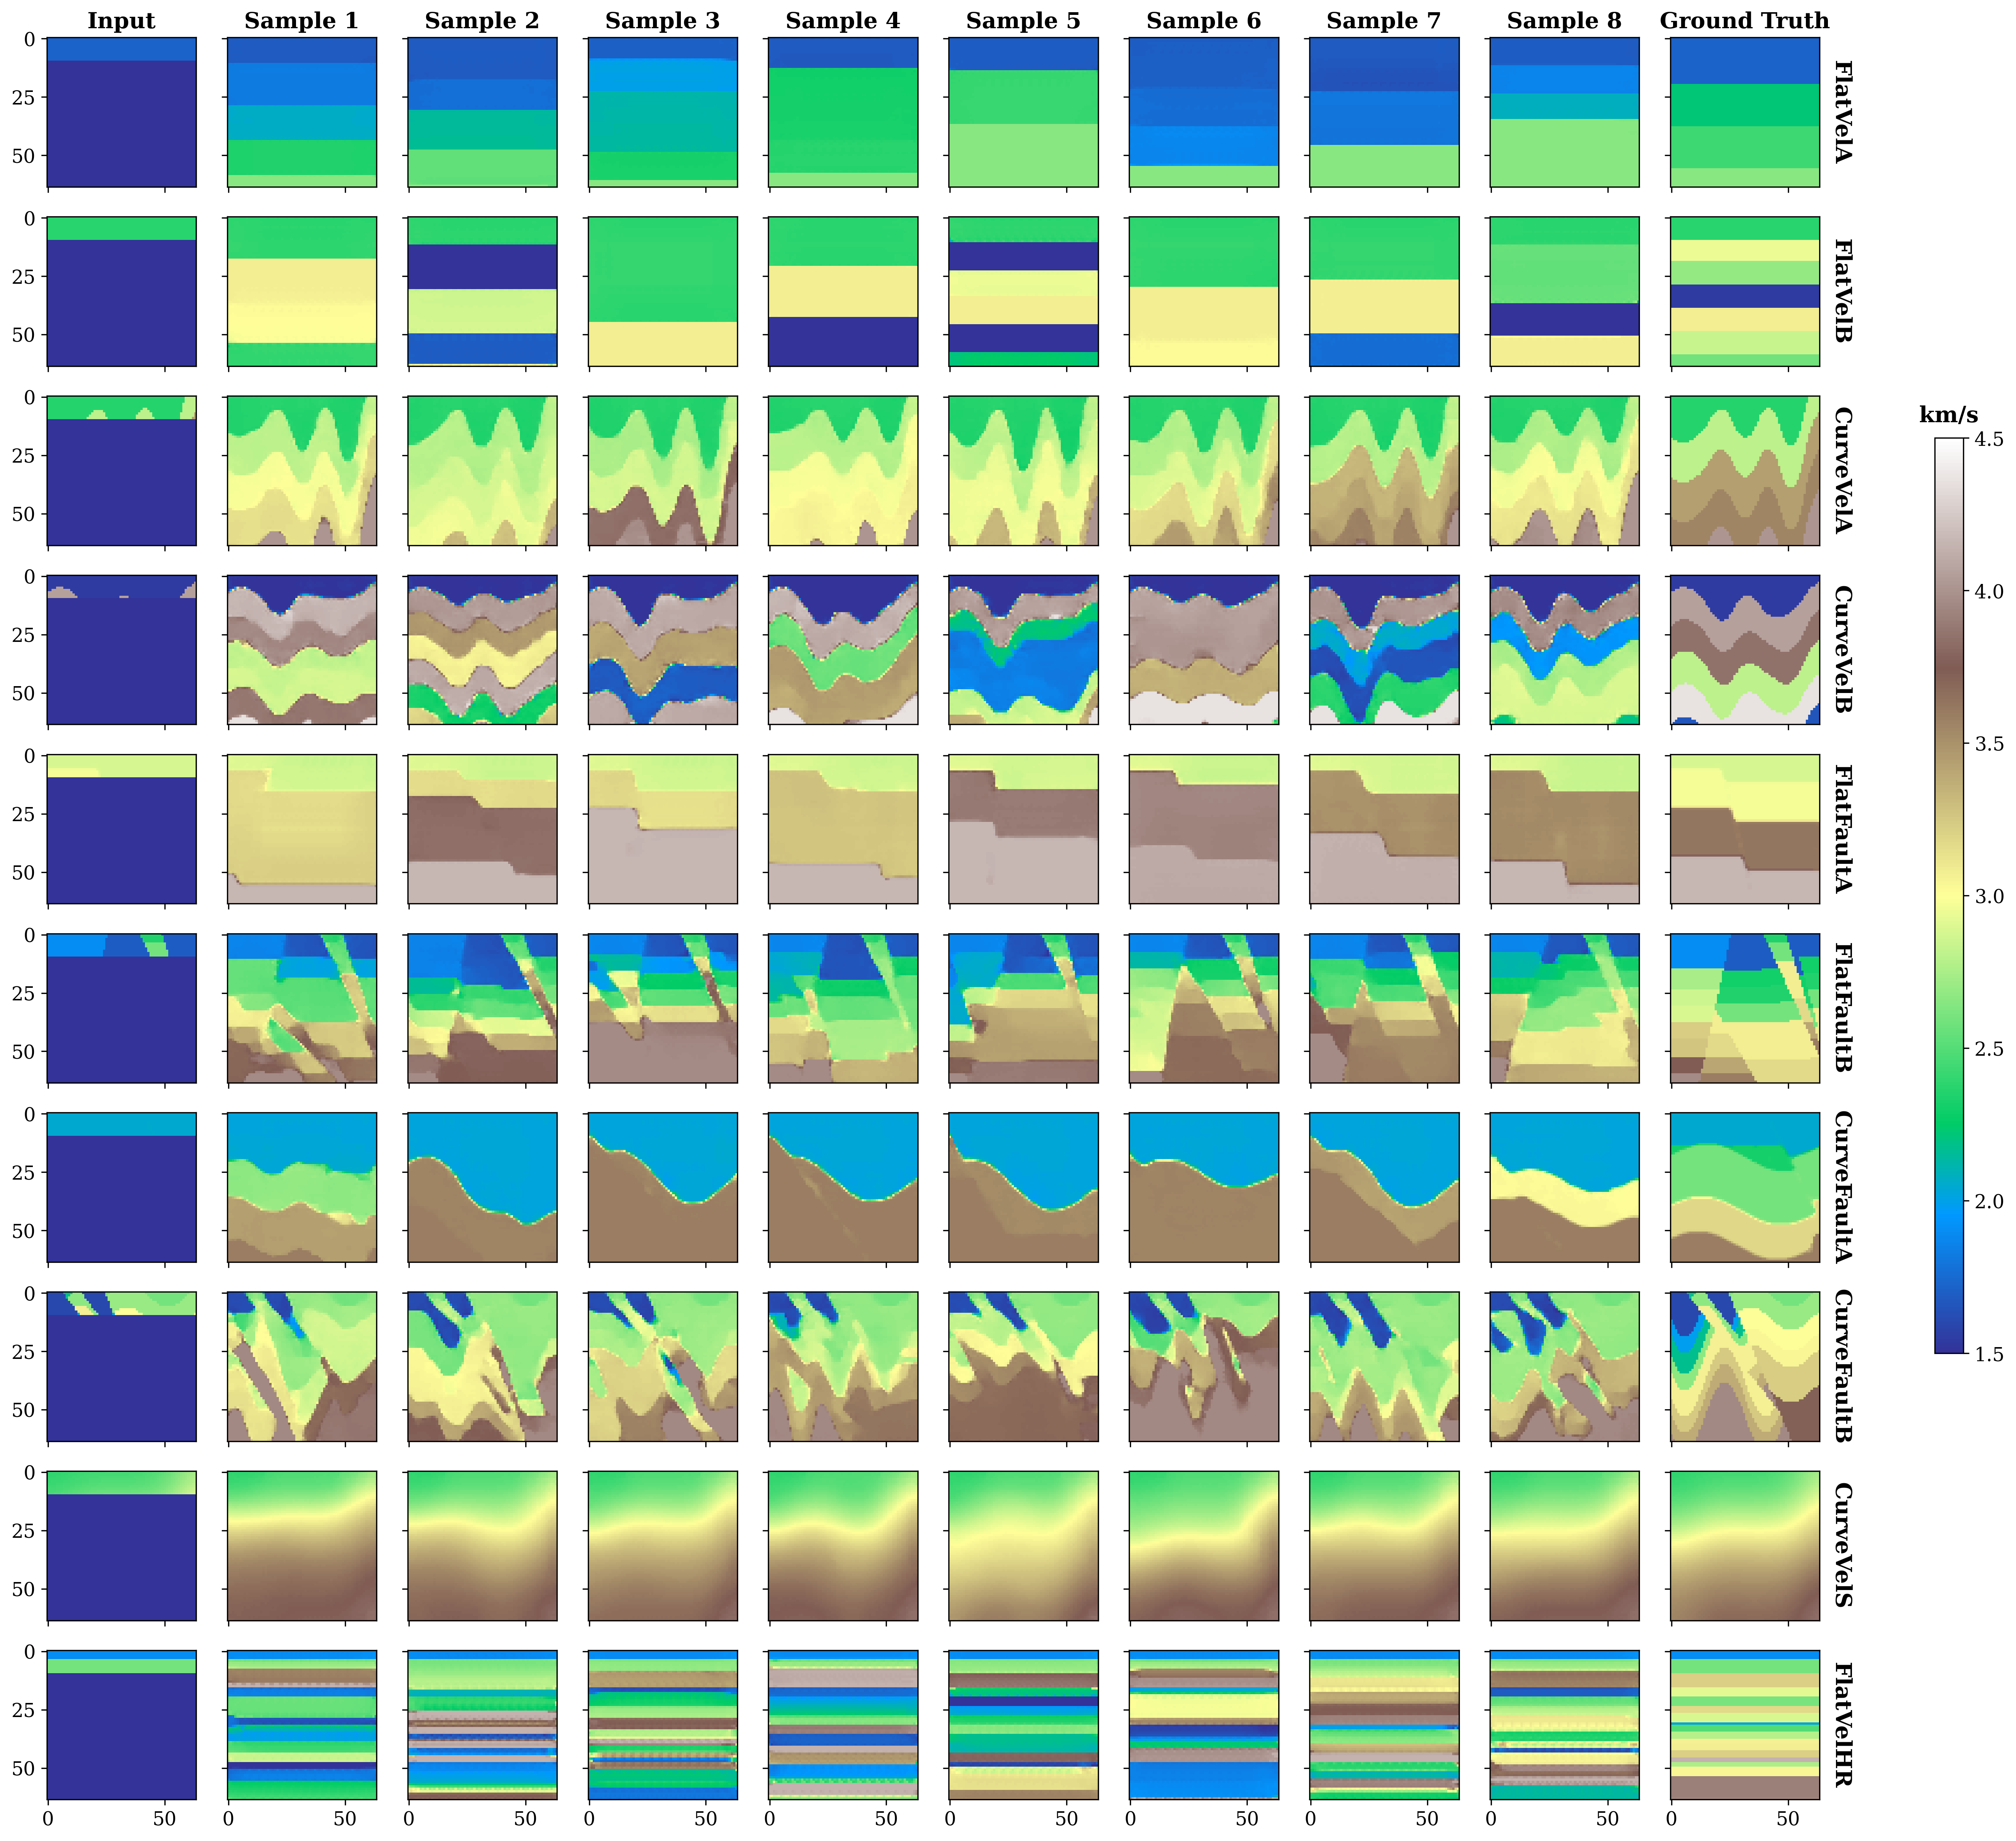

In [106]:
title_y = ["FlatVelA", "FlatVelB", "CurveVelA", "CurveVelB", 
           "FlatFaultA", "FlatFaultB", "CurveFaultA", "CurveFaultB", "CurveVelS", "FlatVelHR"]
plot_example2(vqvae_model, model, test_data, scaler1[1], pad, config, 
              [12001, 18000, 36000, 42007, 24000, 0, 30001, 6000, 48000, 54000],
              idx_gen=[10], n_samples=8, title_y=title_y)

/tmp/ipykernel_22356/3781120202.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.set_ticklabels(np.array(cbar.get_ticks())/1000)


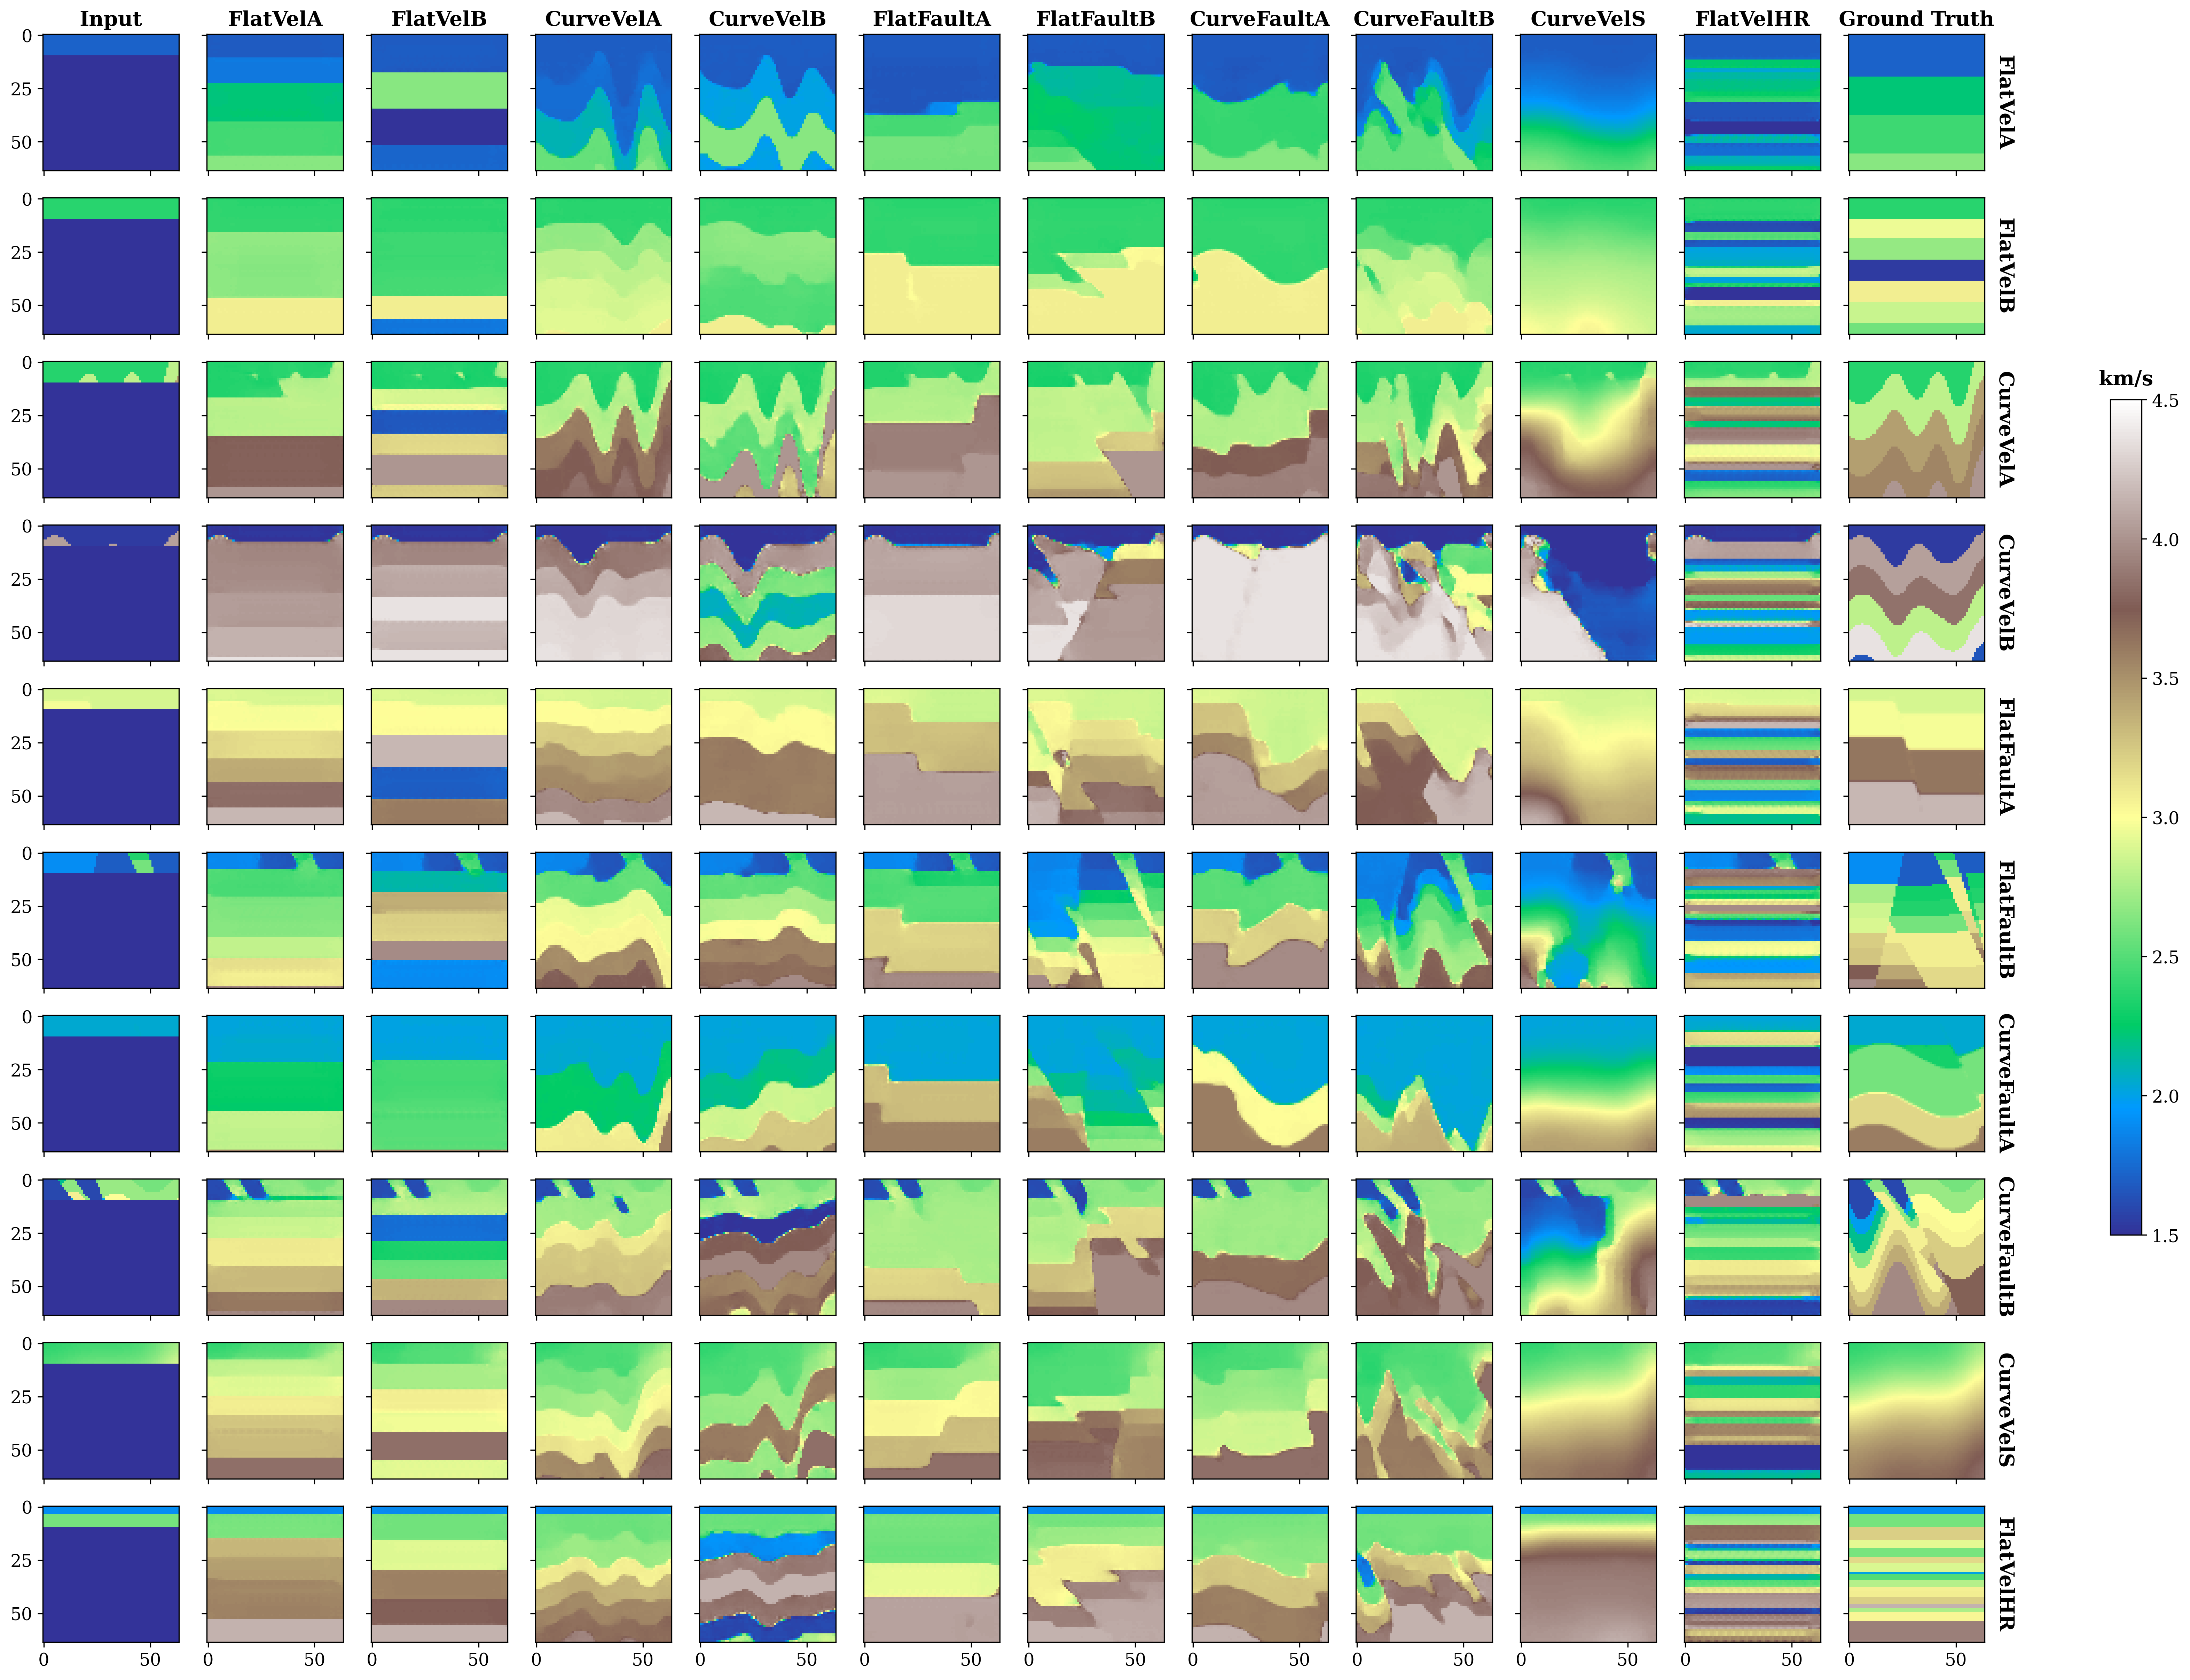

In [107]:
title_x = ["FlatVelA", "FlatVelB", "CurveVelA", "CurveVelB", 
           "FlatFaultA", "FlatFaultB", "CurveFaultA", "CurveFaultB", "CurveVelS", "FlatVelHR"]
title_y = ["FlatVelA", "FlatVelB", "CurveVelA", "CurveVelB", 
           "FlatFaultA", "FlatFaultB", "CurveFaultA", "CurveFaultB", "CurveVelS", "FlatVelHR"]
cls = torch.tensor([2, 3, 6, 7, 4, 0, 5, 1, 8, 9]).to(device)
cls = cls.repeat(1, 10).reshape(10, 10)
plot_example2(vqvae_model, model, test_data, scaler1[1], pad, config, 
              [12001, 18000, 36000, 42007, 24000, 0, 30001, 6000, 48000, 54000],
              idx_gen=[10], cls=cls, n_samples=10, title_x=title_x, title_y=title_y, show_label=True)

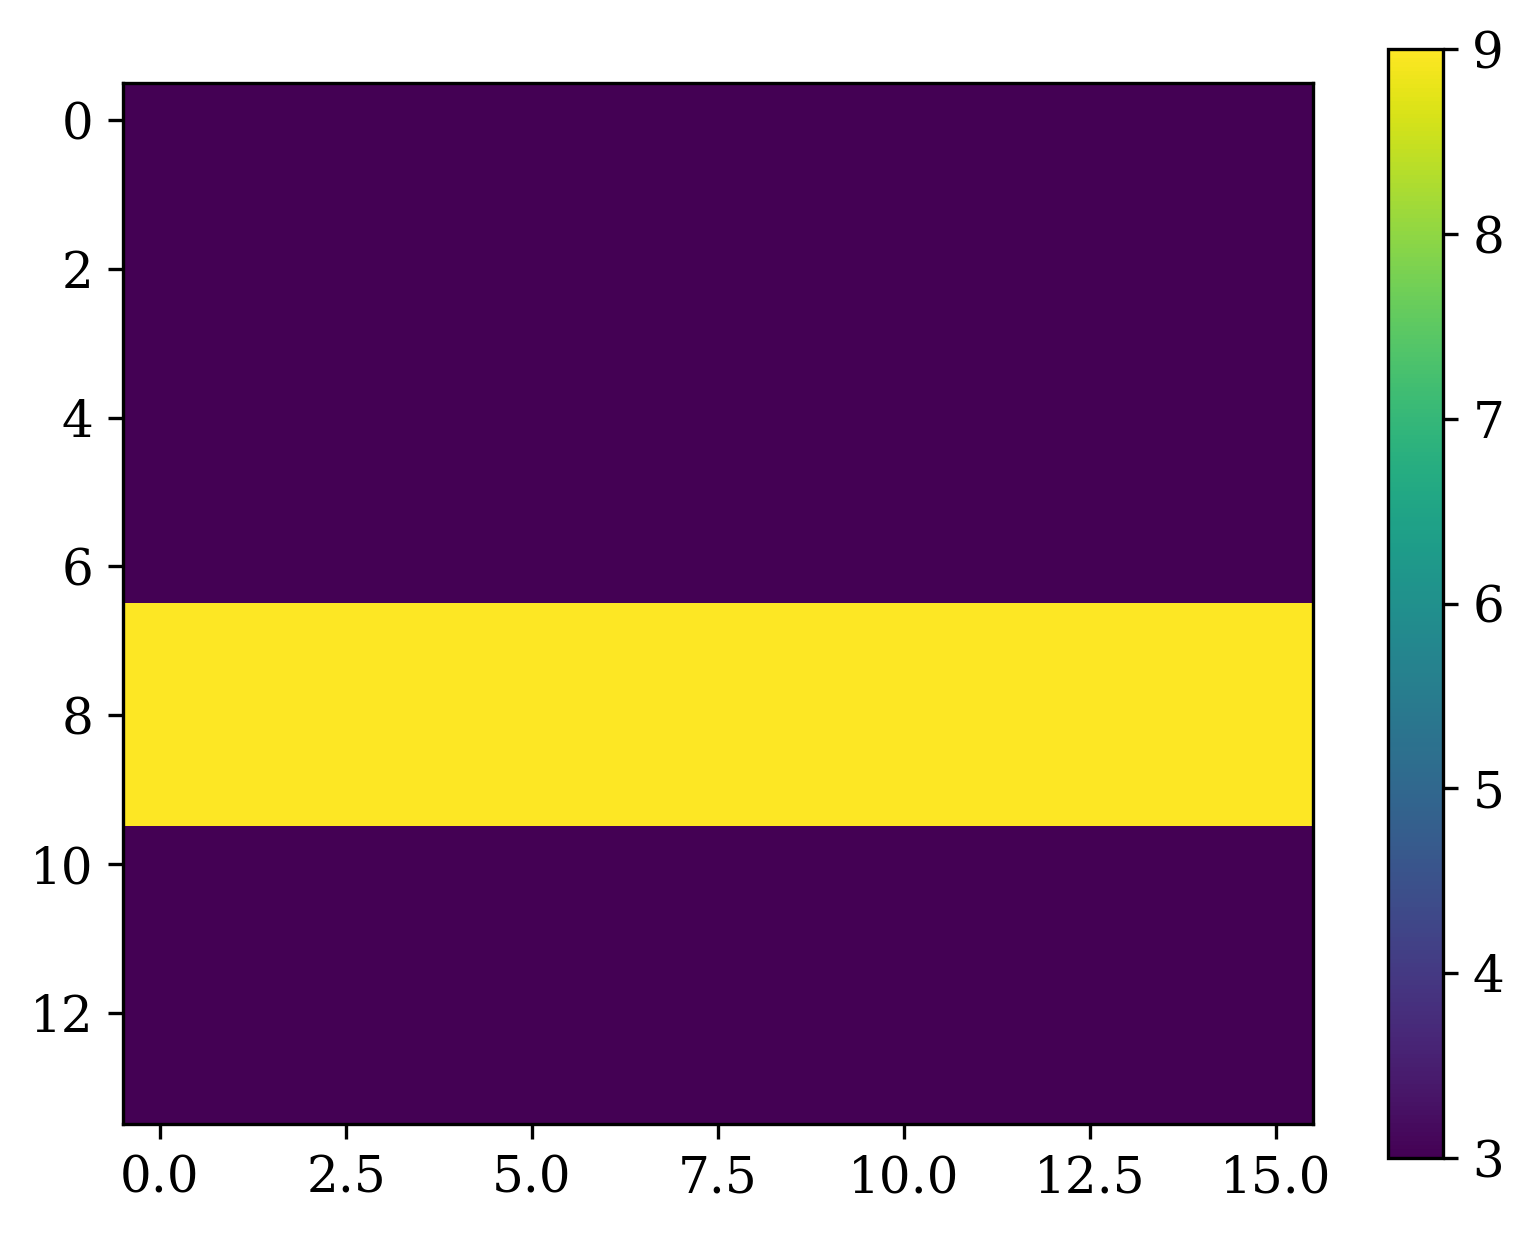

In [178]:
cls1 = torch.zeros(14, 16).long().to(device)
cls1[:, :] = 3
cls1[7:10, :] = 9
cls1 = cls1[None, None, :, :].repeat(1, 4, 1, 1)

plt.imshow(cls1[0, 0].cpu())
plt.colorbar()

/tmp/ipykernel_22356/3781120202.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.set_ticklabels(np.array(cbar.get_ticks())/1000)


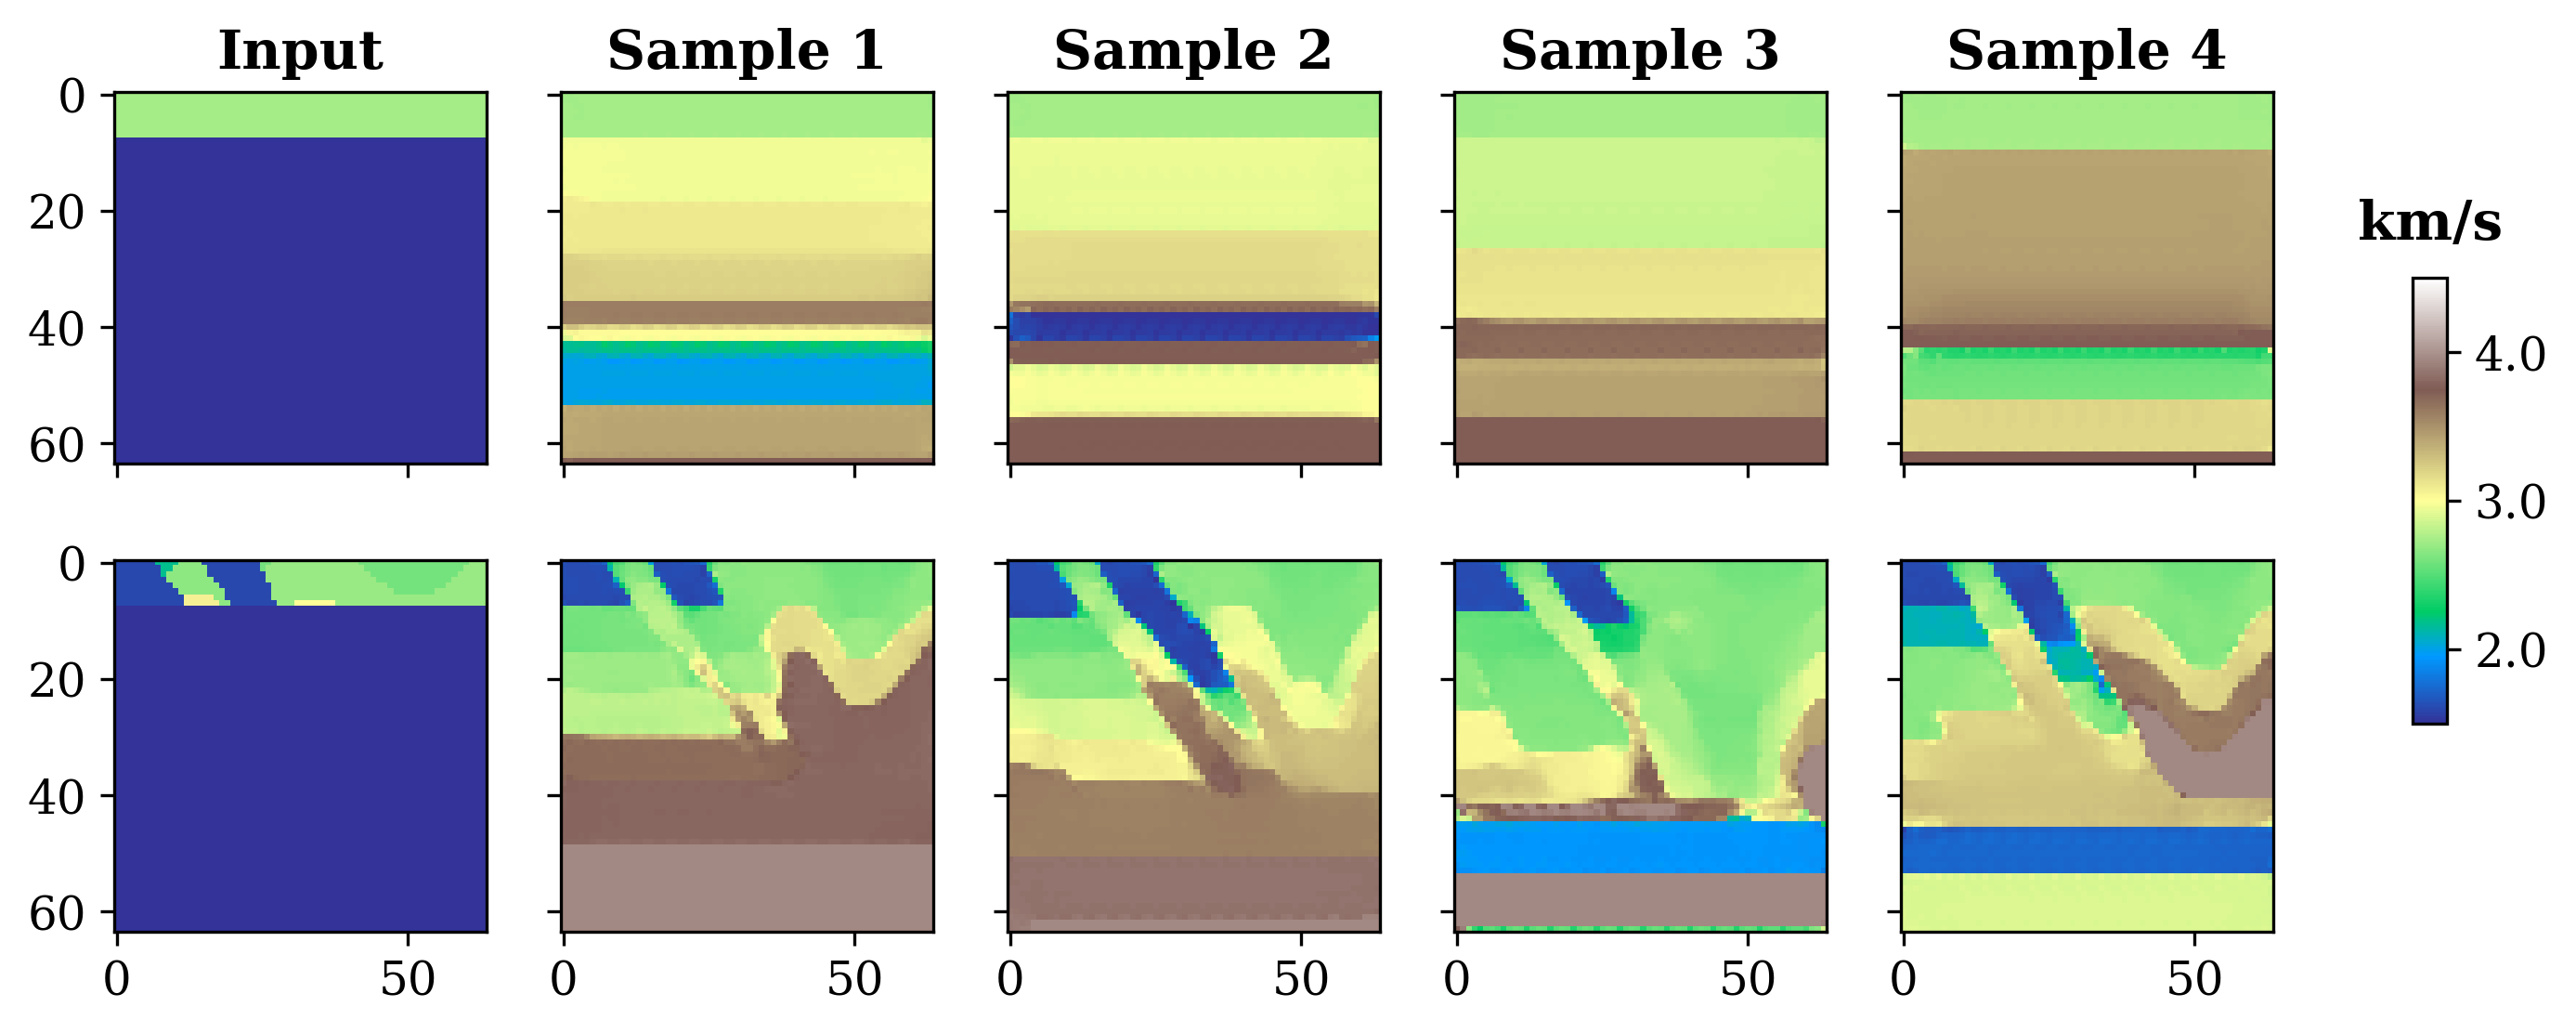

In [219]:
cls1 = torch.zeros(14, 16).long().to(device)
cls1[:, :] = 2
# cls1[8:, :] = 9
cls1[7:10, :] = 9
cls1 = cls1[None, None, :, :].repeat(1, 4, 1, 1).reshape(1, 4, -1)

cls2 = torch.zeros(14, 16).long().to(device)
cls2[:8, :8] = 0
cls2[:8, 8:] = 1
cls2[8:, :] = 3
cls2 = cls2[None, None, :, :].repeat(1, 4, 1, 1).reshape(1, 4, -1)

cls = torch.cat((cls1, cls2), dim=0)

plot_example2(vqvae_model, model, test_data, scaler1[1], pad, config, 
              [12002, 6000],
              idx_gen=[8], cls=cls, n_samples=4, show_label=False)